In [ ]:
import numpy as np
import pandas as pd
import scanpy as sc

import cello

import matplotlib.pyplot as pl
from matplotlib import rcParams

import os


wr_dir = '/Users/jplab/Desktop/DAILY_CODE_DATA/2022-5/data/5-7_singlecell_scanpy_demo'
os.chdir(wr_dir)

cello_resource_loc = '/Users/jplab/Desktop/freq_used_file/'

# verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.verbosity = 3 
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=400)

In [ ]:
filtered_matrix_h5 = "/Users/jplab/Downloads/GSE122960_RAW/GSM3489183_IPF_01_filtered_gene_bc_matrices_h5.h5" 
adata = sc.read_10x_h5(filtered_matrix_h5, genome='GRCh38',gex_only=True)
adata.var_names_make_unique()

adata

normalizing counts per cell
    finished (0:00:00)


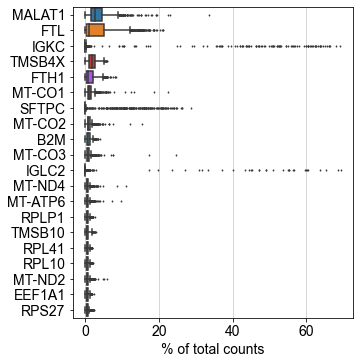

In [4]:
sc.pl.highest_expr_genes(adata, n_top=20)

In [5]:
sc.pp.filter_cells(adata, min_genes=200) # 去除表达基因200以下的细胞 
sc.pp.filter_genes(adata, min_cells=3) # 去除在3个细胞以下表达的基因
adata

filtered out 2 cells that have less than 200 genes expressed
filtered out 14075 genes that are detected in less than 3 cells


AnnData object with n_obs × n_vars = 2251 × 19619
    obs: 'n_genes'
    var: 'gene_ids', 'n_cells'

In [8]:
mito_genes = adata.var_names.str.startswith('MT-')
mito_genes

# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

adata

AnnData object with n_obs × n_vars = 2251 × 19619
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'n_cells'

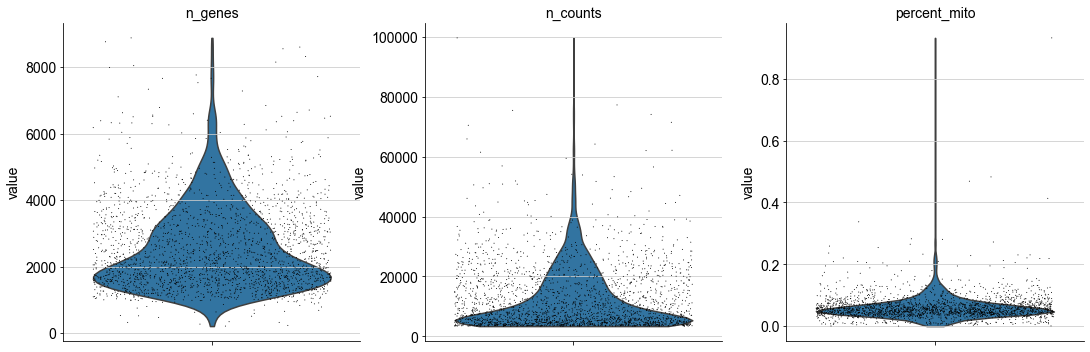

In [9]:
sc.pl.violin(
    adata, 
    ['n_genes', 'n_counts', 'percent_mito'],
    jitter=0.4, multi_panel=True)

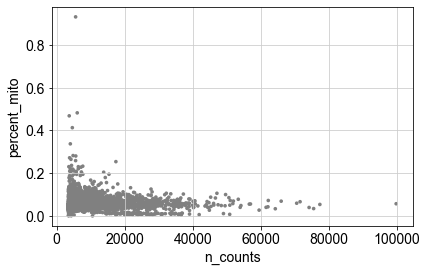

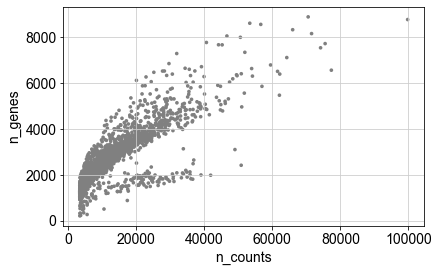

In [10]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')

In [11]:
adata = adata[adata.obs['n_genes'] < 4000, :]
adata = adata[adata.obs['percent_mito'] < 0.3, :]
adata

View of AnnData object with n_obs × n_vars = 1959 × 19619
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'n_cells'

In [12]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
adata

adata.raw = adata
adata.__dict__

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


/opt/anaconda3/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:524: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[key_n_counts] = counts_per_cell


{'_is_view': False,
 '_adata_ref': None,
 '_oidx': None,
 '_vidx': None,
 'file': Backing file manager: no file is set.,
 '_obsm': AxisArrays with keys: ,
 '_varm': AxisArrays with keys: ,
 '_layers': Layers with keys: ,
 '_obsp': PairwiseArrays with keys: ,
 '_varp': PairwiseArrays with keys: ,
 '_obs':                     n_genes  percent_mito  n_counts
 AAACCTGAGCACCGCT-1     3337      0.068522   20271.0
 AAACCTGCACAGATTC-1     1760      0.084758    4271.0
 AAACCTGGTAAGGGCT-1     1972      0.062691    7210.0
 AAACCTGGTCAAACTC-1     3212      0.038487   13615.0
 AAACCTGGTGCAACGA-1     3008      0.052047   19636.0
 ...                     ...           ...       ...
 TTTGGTTTCTTGTTTG-1     1095      0.032908    4467.0
 TTTGTCAAGCCACGTC-1     2847      0.059589   13224.0
 TTTGTCACACGTCAGC-1     1491      0.033326    4561.0
 TTTGTCACACTTACGA-1     2984      0.076697    7484.0
 TTTGTCAGTGACGCCT-1     1990      0.041517    6937.0
 
 [1959 rows x 3 columns],
 '_var':                       

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


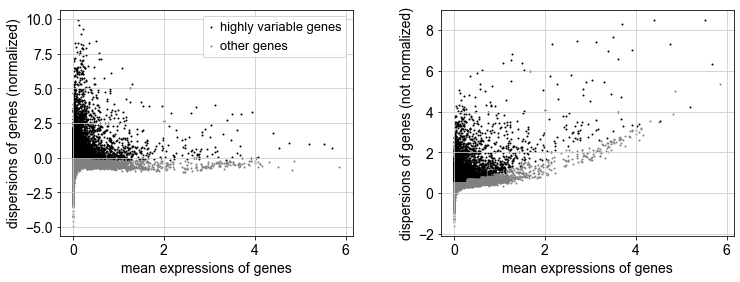

View of AnnData object with n_obs × n_vars = 1959 × 10084
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

In [13]:
# sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pp.highly_variable_genes(adata, n_top_genes=10000)
sc.pl.highly_variable_genes(adata)

adata = adata[:, adata.var['highly_variable']]
adata

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


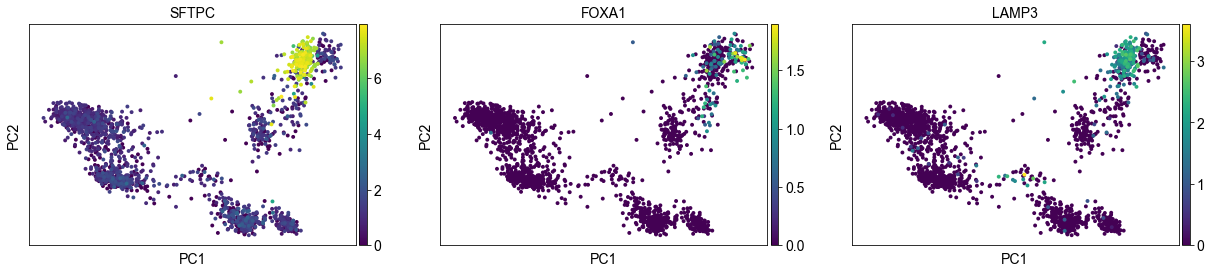

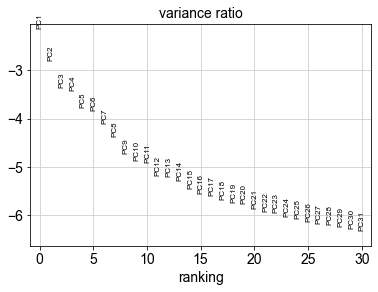

In [14]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca(adata, color=['SFTPC','FOXA1','LAMP3'])
sc.pl.pca_variance_ratio(adata, log=True)

adata.write("pca_results.h5ad")

In [15]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=15)

sc.tl.leiden(adata, resolution=2.0)

computing neighbors
    using 'X_pca' with n_pcs = 15
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)
running Leiden clustering
    finished: found 26 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


In [16]:
adata.X = adata.X.todense()
adata

AnnData object with n_obs × n_vars = 1959 × 10084
    obs: 'n_genes', 'percent_mito', 'n_counts', 'leiden'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'leiden'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [ ]:
model_prefix = 'GSM3489183_IPF_01_filtered_gene_bc_matrices_h5_try2'

cello.scanpy_cello(
  adata,
  clust_key='leiden',
  rsrc_loc=cello_resource_loc,
  out_prefix=model_prefix,
  log_dir=cello_resource_loc
)

print('Done!')

In [18]:
adata.obs

,n_genes,percent_mito,n_counts,leiden,early embryonic cell (probability),cultured cell (probability),germ line stem cell (probability),male germ cell (probability),male germ line stem cell (probability),spermatocyte (probability),...,epithelial cell of alveolus of lung (binary),mononuclear cell of bone marrow (binary),spinal cord motor neuron (binary),precursor cell (binary),lung secretory cell (binary),trophectodermal cell (binary),bone marrow hematopoietic cell (binary),peripheral blood mononuclear cell (binary),central nervous system neuron (binary),Most specific cell type
AAACCTGAGCACCGCT-1,3337,0.068522,20271.0,10,0.000142,0.010392,0.000088,0.000053,0.000053,0.000050,...,False,False,False,False,False,False,False,False,False,alveolar macrophage
AAACCTGCACAGATTC-1,1760,0.084758,4271.0,23,0.000039,0.069548,0.004733,0.002411,0.002411,0.000013,...,False,False,False,False,False,False,False,False,False,supportive cell
AAACCTGGTAAGGGCT-1,1972,0.062691,7210.0,6,0.000401,0.830921,0.001156,0.000620,0.000620,0.000112,...,True,False,False,False,True,False,False,False,False,type II pneumocyte
AAACCTGGTCAAACTC-1,3212,0.038487,13615.0,5,0.000050,0.033943,0.000111,0.000075,0.000075,0.000034,...,False,False,False,False,False,False,False,True,False,"myeloid dendritic cell, human"
AAACCTGGTGCAACGA-1,3008,0.052047,19636.0,2,0.000119,0.018569,0.000105,0.000063,0.000063,0.000039,...,False,False,False,False,False,False,False,False,False,alveolar macrophage
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGTTTCTTGTTTG-1,1095,0.032908,4467.0,0,0.000023,0.001845,0.000241,0.000224,0.000224,0.000224,...,False,False,False,False,False,False,False,False,False,class switched memory B cell
TTTGTCAAGCCACGTC-1,2847,0.059589,13224.0,6,0.000401,0.830921,0.001156,0.000620,0.000620,0.000112,...,True,False,False,False,True,False,False,False,False,type II pneumocyte
TTTGTCACACGTCAGC-1,1491,0.033326,4561.0,2,0.000119,0.018569,0.000105,0.000063,0.000063,0.000039,...,False,False,False,False,False,False,False,False,False,alveolar macrophage
TTTGTCACACTTACGA-1,2984,0.076697,7484.0,12,0.000009,0.003591,0.006962,0.011148,0.006962,0.005259,...,False,False,False,False,False,False,False,False,False,epithelial cell of upper respiratory tract


In [19]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:02)


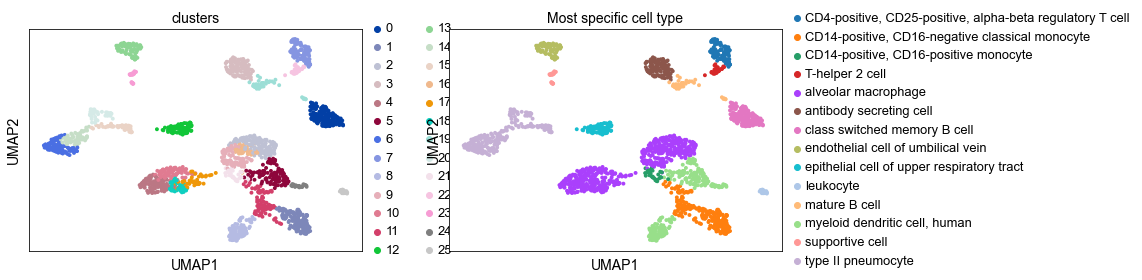

In [20]:
sc.pl.umap(adata, color=['leiden','Most specific cell type'],title='clusters')

## Manual cell annotation with markers

In [22]:
AT1_cells = ['MMP11', 'ICAM1', 'CTGF', 'SEMA3B', 'SCNN1B', 'SEMA3E', 'SCNN1G', 'SCNN1A', 'COL4A4', 'CYP4B1', 'RTKN2', 'CLIC5', 'AKAP5', 'GPRC5A', 'SEC14L3', 'COL4A3', 'CLDN18', 'AGER', 'HOPX', 'AQP5', 'EMP2', 'VEGFA', 'KRT7', 'IGFBP6', 'PXDC1', 'AQP3', 'CRLF1', 'EGFL6', 'FSTL3', 'MEX3B', 'RADIL', 'SMARCA1', 'P2RX7', 'PDPN']
AT2_cells = ['IRX1', 'EGFL6', 'CEBPA', 'NKX2-1', 'MUC1', 'CLDN18', 'AGER', 'LAMP3', 'SFTA2', 'SFTPD', 'SLC34A2', 'SFTPB', 'SFTPA1', 'SFTPC', 'SDC1', 'ADGRF5', 'ABCD3', 'SOAT1', 'ETV5', 'CD36', 'LPCAT1', 'NAPSA', 'ABCA3', 'S100G', 'PGC', 'CXCR2', 'CXCL2', 'GRK2', 'RUNX3', 'CTNND1', 'PPP1R14C', 'DDX3Y', 'PIGR', 'LRG1', 'NRN1', 'PPBP', 'IL1B', 'INMT', 'CRLF1']

In [ ]:
#visualize the gene expression as an overlay of the umap
#(this way you can visually identify the clusters with a high expression))
sc.pl.umap(adata, color = AT1_cells, color_map = 'viridis', ncols = len(AT1_cells))
sc.pl.umap(adata, color = AT2_cells, color_map = 'viridis', ncols = len(AT2_cells))
sc.pl.umap(adata, color = ['leiden'], color_map = 'viridis', ncols = 3)